In [1]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

# Clustering

In [9]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

## Create data

In [31]:
n_clusters=6
n_samples =250

In [32]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

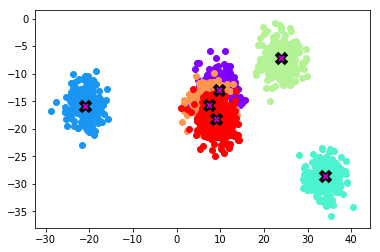

In [33]:
kmeans.plot_data(centroids, data, n_samples)

## K means

In [6]:
k = Kmeans(data, n_clusters)

In [9]:
sess = tf.InteractiveSession()

In [24]:
tf.global_variables_initializer().run()
initial_centroids = k.find_initial_centroids(n_clusters).eval()

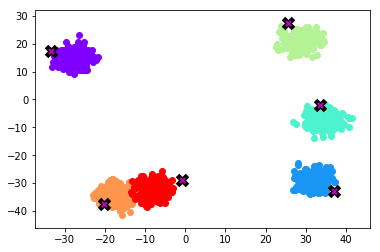

In [25]:
kmeans.plot_data(initial_centroids, data, n_samples)

In [27]:
curr_centroids = tf.Variable(initial_centroids)
nearest_indices = k.assign_to_nearest(curr_centroids)
updated_centroids = k.update_centroids(nearest_indices)
tf.global_variables_initializer().run()

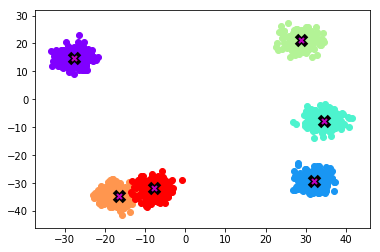

In [28]:
kmeans.plot_data(updated_centroids.eval(), data, n_samples)

In [ ]:
curr_centroids.assign(updated_centroids)

In [7]:
with tf.Session().as_default(): new_centroids = k.run()

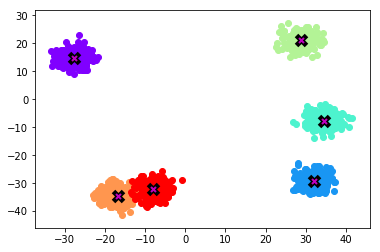

In [8]:
kmeans.plot_data(new_centroids, data, n_samples)

## Mean shift

In [237]:
def gaussian(d, bw):
    return np.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [272]:
def meanshift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (np.expand_dims(weight,1)*X).sum(0) / weight.sum()
    return X

In [273]:
%time X=meanshift(data)

CPU times: user 1 s, sys: 8 ms, total: 1.01 s
Wall time: 1.01 s


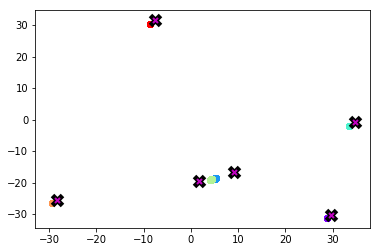

In [274]:
kmeans.plot_data(centroids+1, X, n_samples)

## PyTorch

In [3]:
import torch_utils; reload(torch_utils)
from torch_utils import *

In [4]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [275]:
def meanshift(data):
    X = torch.FloatTensor(np.copy(data))
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt((sub(x, X)**2).sum(1))
            weight = gaussian(dist, 3)
            num = mul(weight, X).sum(0)
            X[i] = num / weight.sum()
    return X

In [277]:
%time X = meanshift(data).numpy()

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


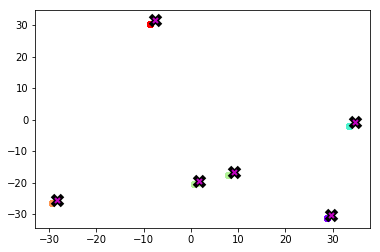

In [217]:
kmeans.plot_data(centroids+1, X, n_samples)

### GPU

In [39]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [38]:
a=torch.rand(2,2)
b=torch.rand(3,2)
dist_b(b, a).squeeze(2)


 0.9036  0.6772  0.9950
 0.5185  0.3260  0.6215
[torch.FloatTensor of size 2x3]

In [35]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [36]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [37]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [49]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 44.8 ms


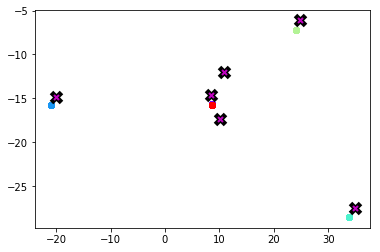

In [50]:
kmeans.plot_data(centroids+1, X, n_samples)

## LSH

In [79]:
from sklearn.neighbors import LSHForest, KDTree, BallTree

In [6]:
n_clusters=6
n_samples =2500

In [100]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

In [63]:
nn = KDTree(data)
nearest = nn.query(data[:10], 3, False); nearest

array([[   0,  867, 2008],
       [   1,  116,  707],
       [   2, 1916, 1354],
       [   3,  204,  389],
       [   4, 2210, 2096],
       [   5,   59, 1824],
       [   6, 2019, 1933],
       [   7, 2195,  135],
       [   8, 1020,  660],
       [   9, 2471, 1253]])

In [80]:
nn = BallTree(data)
nearest = nn.query(data[:10], 3, False); nearest

array([[    0,  1488, 10885],
       [    1,  9281, 11641],
       [    2,   510, 12097],
       [    3,   319,   381],
       [    4,    20,  1481],
       [    5,   370,  1302],
       [    6,   459,  1415],
       [    7,   149,  2085],
       [    8,  1398,   421],
       [    9,   386,   343]])

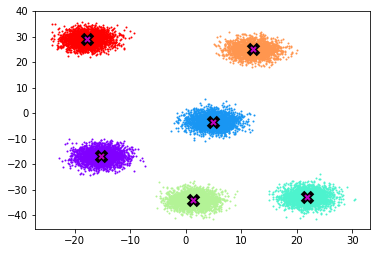

In [101]:
kmeans.plot_data(centroids, data, n_samples)

In [74]:
def index_b(a,idxs):
    ir, ic = idxs.size()
    ar, ac = a.size()
    return a[idxs.view(ir*ic)].view(ir,ic,ac)

In [19]:
a = FT([[1,2],[3.,4],[5,6]])
b = torch.LongTensor([[0,1], [1,2]])
exp = FT([[[1,2], [3,4.]], [[3,4], [5,6]]])
assert(torch.equal(index_b(a,b), exp))

In [75]:
def dist_b_n(a,b,pts):
    dists = sub(pts,b.unsqueeze(1))**2
    return torch.sqrt(dists.sum(2))

In [102]:
def meanshift(data, bs=512):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        d = X.cpu().numpy()
        nn = BallTree(d)
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            nearest = torch.LongTensor(nn.query(d[s], 50, False)).cuda()
            pts = index_b(X, nearest)
            weight = gaussian(dist_b_n(X, X[s], pts), 2)
            num = sum_sqz(mul(weight, pts), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [107]:
%time data = meanshift(data).cpu().numpy()

CPU times: user 656 ms, sys: 0 ns, total: 656 ms
Wall time: 654 ms


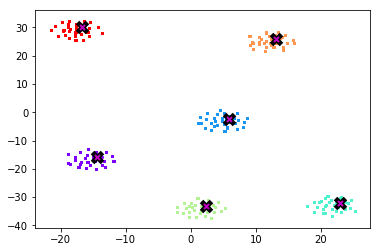

In [108]:
kmeans.plot_data(centroids+1, data, n_samples)